In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from pathlib import Path
import SimpleITK as sitk
import numpy as np

from picai_eval import evaluate_folder
from report_guided_annotation import extract_lesion_candidates

If you have questions or suggestions, feel free to open an issue at https://github.com/DIAGNijmegen/picai_eval



Please cite the following paper when using Report Guided Annotations:

Bosma, J.S., et al. "Semi-supervised learning with report-guided lesion annotation for deep learning-based prostate cancer detection in bpMRI" to be submitted


If you have questions or suggestions, feel free to open an issue at https://github.com/DIAGNijmegen/Report-Guided-Annotation



In [2]:
def absolute_error(gt, pred):
    return np.abs(gt - pred)

In [3]:
pred_dir = Path("../data/picaiv2")
model = "unet-eval"
model_dir = pred_dir / model

img_dir = Path("/cluster/projects/vc/data/mic/open/Prostate/PI-CAI-V2.0/images")

In [4]:
metrics = evaluate_folder(
    y_true_dir=model_dir,
    y_det_dir=model_dir,
    y_det_postprocess_func=lambda pred: extract_lesion_candidates(pred)[0],
)

metrics

Found 258 files in the input directory, collecting detection_mapes with ['_detection_map.npz', '_detection_map.npy', '_detection_map.nii.gz', '_detection_map.nii', '_detection_map.mha', '_detection_map.mhd'] and labels with ['_label.nii.gz', '_label.nii', '_label.mha', '_label.mhd', '_label.npz', '_label.npy'].
Found prediction and label for 129 cases. Here are some examples:
['10002_1000002', '10005_1000005', '10009_1000009', '10010_1000010', '10012_1000012']


Evaluating: 100%|██████████| 129/129 [01:44<00:00,  1.24it/s]


Metrics(auroc=80.63%, AP=40.60%, 129 cases, 23 lesions)

In [5]:
gt = metrics.case_target
pred = metrics.case_pred
absolute_errors = np.array([absolute_error(gt, pred) for gt, pred in zip(gt.values(), pred.values())])

In [6]:
min_idxs = np.argsort(absolute_errors)
positive_idxs = min_idxs[np.array(list(gt.values()))[min_idxs] == 1]
negative_idxs = min_idxs[np.array(list(gt.values()))[min_idxs] == 0]

In [7]:
def plot_slice(idx: int, depth_idx: int, out_name: str):
    case_id = list(metrics.case_target.keys())[idx]
    absolute_error = absolute_errors[idx]
    pred_id1, pred_id2 = case_id.split("_")
    img = sitk.GetArrayFromImage(sitk.ReadImage(img_dir / Path(f"{pred_id1}") / f"{pred_id1}_{pred_id2}_t2w.mha"))
    raw = nib.load(model_dir / f"{pred_id1}_{pred_id2}_detection_map.nii.gz").get_fdata()
    det = extract_lesion_candidates(raw)[0]
    gt = nib.load(model_dir / f"{pred_id1}_{pred_id2}_label.nii.gz").get_fdata()

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Case ID: {case_id}, Absolute Error: {absolute_error:.2f}")
    plt.subplot(1, 3, 1)
    plt.title("Ground Truth")
    plt.imshow(img[depth_idx, :, :], cmap="gray")
    plt.imshow(np.ma.masked_where(gt[:, :, depth_idx] == 0, gt[:, :, depth_idx]), cmap="autumn", alpha=0.7)
    plt.axis("off")
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.title("Detection Map (Raw)")
    plt.imshow(img[depth_idx, :, :], cmap="gray")
    plt.imshow(
        np.ma.masked_where(raw[:, :, depth_idx] < 0.1, raw[:, :, depth_idx]),
        alpha=0.7,
        cmap="coolwarm",
        vmin=0,
        vmax=1,
    )
    plt.axis("off")
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.title("Lesion Candidates (Postprocessed)")
    plt.imshow(img[depth_idx, :, :], cmap="gray")
    plt.imshow(
        np.ma.masked_where(det[:, :, depth_idx] < 0.1, det[:, :, depth_idx]),
        alpha=0.7,
        cmap="coolwarm",
        vmin=0,
        vmax=1,
    )
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_name, dpi=300)

In [8]:
def plot_slice_sequence(idx: int):
    case_id = list(metrics.case_target.keys())[idx]
    absolute_error = absolute_errors[idx]
    pred_id1, pred_id2 = case_id.split("_")
    img = sitk.GetArrayFromImage(sitk.ReadImage(img_dir / Path(f"{pred_id1}") / f"{pred_id1}_{pred_id2}_t2w.mha"))
    raw = nib.load(model_dir / f"{pred_id1}_{pred_id2}_detection_map.nii.gz").get_fdata()
    det = extract_lesion_candidates(raw)[0]
    gt = nib.load(model_dir / f"{pred_id1}_{pred_id2}_label.nii.gz").get_fdata()

    def plot_sequences(depth_idx):
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Case ID: {case_id}, Absolute Error: {absolute_error:.2f}")
        plt.subplot(1, 3, 1)
        plt.title("Ground Truth")
        plt.imshow(img[depth_idx, :, :], cmap="gray")
        plt.imshow(np.ma.masked_where(gt[:, :, depth_idx] == 0, gt[:, :, depth_idx]), cmap="autumn", alpha=0.7)
        plt.axis("off")
        plt.tight_layout()

        plt.subplot(1, 3, 2)
        plt.title("Detection Map (Raw)")
        plt.imshow(img[depth_idx, :, :], cmap="gray")
        plt.imshow(
            np.ma.masked_where(raw[:, :, depth_idx] < 0.1, raw[:, :, depth_idx]),
            alpha=0.7,
            cmap="coolwarm",
            vmin=0,
            vmax=1,
        )
        plt.axis("off")
        plt.tight_layout()

        plt.subplot(1, 3, 3)
        plt.title("Lesion Candidates (Postprocessed)")
        plt.imshow(img[depth_idx, :, :], cmap="gray")
        plt.imshow(
            np.ma.masked_where(det[:, :, depth_idx] < 0.1, det[:, :, depth_idx]),
            alpha=0.7,
            cmap="coolwarm",
            vmin=0,
            vmax=1,
        )
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")
        plt.tight_layout()

    # Create slider for frame selection
    interact(
        plot_sequences,
        depth_idx=IntSlider(min=0, max=img.shape[0] - 1, step=1, value=0),
    )

In [12]:
plot_slice_sequence(positive_idxs[-1])

interactive(children=(IntSlider(value=0, description='depth_idx', max=26), Output()), _dom_classes=('widget-in…

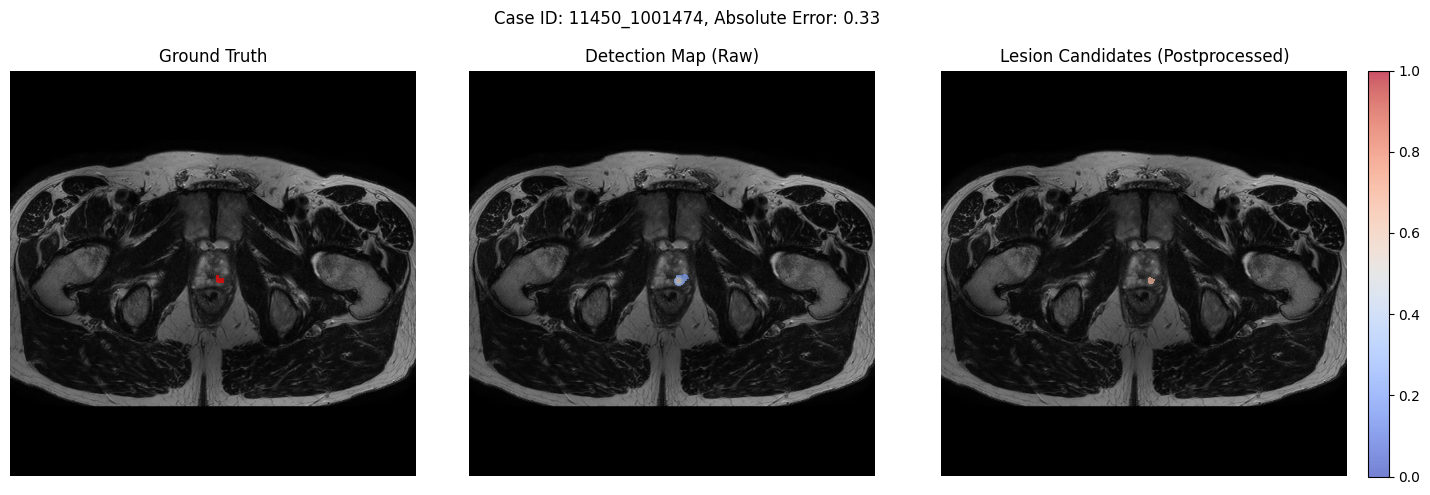

In [13]:
plot_slice(positive_idxs[len(positive_idxs) // 2], depth_idx=10, out_name=f"picai_preds/{model}-positive-median.png")